In [1]:
import scipy.linalg as la
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
from helper_functions.grape_functions import get_state_index
from main_grape.Grape import Grape
from IPython import display
import numpy as np
%pylab inline


/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')

Populating the interactive namespace from numpy and matplotlib


pylab import has clobbered these variables: ['display']
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
total_time = 50.0
steps = 2000



#Defining H0
qubit_state_num = 4
alpha = -0.3
fq = 4.105
ens = 2*np.pi*(fq*np.arange(qubit_state_num)+alpha*(np.arange(qubit_state_num)-1)*(np.arange(qubit_state_num))/2.)


mode_state_num = 3
qm_g1 = 2.*np.pi*0.2 #GHz
mode_freq1 = 6.0 #GHz
mode_ens1 = np.array([ 2*np.pi*ii*(mode_freq1) for ii in np.arange(mode_state_num)])
qm_g2 = 2.*np.pi*0.2 #GHz
#mode_freq2 = 5.327 #GHz
mode_freq2 = 6.5 #GHz
mode_ens2 = np.array([ 2*np.pi*ii*(mode_freq2) for ii in np.arange(mode_state_num)])
state_num = qubit_state_num * (mode_state_num**2)
Q_x   = np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)+np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1)
Q_y   = (0+1j) *(np.diag(np.sqrt(np.arange(1,qubit_state_num)),1)-np.diag(np.sqrt(np.arange(1,qubit_state_num)),-1))
Q_z   = np.diag(ens-ens[0])/(2*np.pi*fq)
M_x = np.diag(np.sqrt(np.arange(1,mode_state_num)),1)+np.diag(np.sqrt(np.arange(1,mode_state_num)),-1)
I_q = np.identity(qubit_state_num)
I_m = np.identity(mode_state_num)
H_q = np.diag(ens-ens[0])
H_m1 = np.diag(mode_ens1)
H_m2 = np.diag(mode_ens2)
H0 = np.kron(H_q,np.kron(I_m,I_m)) + np.kron(I_q,np.kron(H_m1,I_m)) +\
        np.kron(I_q,np.kron(I_m,H_m2)) + qm_g1*np.kron(Q_x,np.kron(M_x,I_m)) +\
        qm_g2*np.kron(Q_x,np.kron(I_m,M_x))
#H0 = np.zeros([state_num,state_num])
#Defining Dressed information for our multimode exp        
w_c, v_c = la.eig(H0)
dressed=[]
D= True
if D:
    for ii in range (len(v_c)):
        index=np.argmax(np.abs(v_c[:,ii]))
        if index not in dressed:
            dressed.append(index)
        else:
            temp= (np.abs(v_c[:,ii])).tolist()
            while index in dressed:

                temp.remove(max(temp))
                index2= np.argmax(np.array(temp))

                if index2<index:
                            #dressed.append(index2)
                    index=index2
                else:
                            #dressed.append(index2-1)
                    index=index2+1
            dressed.append(index)

#Defining Forbidden sates
states_h = range(3*mode_state_num**2,4*mode_state_num**2)
states_gef02 = [2,mode_state_num**2+2,2*mode_state_num**2+2]
states_gef20 = [2*mode_state_num,mode_state_num**2+2*mode_state_num,2*mode_state_num**2+2*mode_state_num]
states_forbidden_list = states_h + states_gef02 + states_gef20

#Defining Concerned states (starting states)
psi0 = [0,1,mode_state_num,mode_state_num+1]

#Defining states to include in the drawing of occupation
states_draw_list = [0,1,mode_state_num,mode_state_num+1,mode_state_num**2]
states_draw_names = ['g00','g01','g10','g11','e00']

#Defining U (Target)
g11=get_state_index(mode_state_num+1,dressed)
g10=get_state_index(mode_state_num,dressed)

print g11,g10

if D:
    Ct_c= np.identity(state_num) - np.outer(v_c[:,g10], np.conjugate((v_c[:,g10])))
    Ct_c= Ct_c - np.outer(v_c[:,g11], np.conjugate((v_c[:,g11])))
    Ct_c= Ct_c + np.outer(v_c[:,g10], np.conjugate((v_c[:,g11])))
    Ct_c= Ct_c + np.outer(v_c[:,g11], np.conjugate((v_c[:,g10])))
else:
    #Ut_c = la.expm((0-1j)*total_time*H0)
    #Ct_c = Ut_c.copy()
    Ct_c = np.identity(state_num)
    Ct_c[g11,g10] = 1
    Ct_c[g10,g11] = 1
    Ct_c[g10,g10] = 0
    Ct_c[g11,g11] = 0
U = Ct_c

#Defining U0 (Initial)
q_identity = np.identity(qubit_state_num)
m_identity = np.identity(mode_state_num)
U0= np.kron(q_identity,np.kron(m_identity,m_identity))

#Defining control Hs
XI = np.kron(Q_x,np.kron(I_m,I_m))
ZI = np.kron(Q_z,np.kron(I_m,I_m))
Hops = [XI,ZI]
ops_max_amp = [4.0,4.0*2*np.pi]
Hnames =['x','z']

#Defining convergence parameters
max_iterations = 5000
decay = max_iterations/2
convergence = {'rate':0.005, 'update_step':100, 'max_iterations':max_iterations,\
               'conv_target':1e-8,'learning_rate_decay':decay}
penalty_coeffs = {'envelope' : 0.1, 'dc':0.01, 'dwdt':0.01,'d2wdt2':0, 'forbidden':100.0}
multi_mode = {'dressed':dressed, 'vectors':v_c, 'qnum':qubit_state_num, 'mnum': mode_state_num,\
              'f':fq, 'es':w_c, 'g1':qm_g1, 'D':D, 'Interpolation':False, 'Modulation':False}


print psi0
print H_q
print H_m1
print H_m2

12 8
[0, 1, 3, 4]
[[  0.           0.           0.           0.        ]
 [  0.          25.79247569   0.           0.        ]
 [  0.           0.          49.69999578   0.        ]
 [  0.           0.           0.          71.72256028]]
[[  0.           0.           0.        ]
 [  0.          37.69911184   0.        ]
 [  0.           0.          75.39822369]]
[[  0.           0.           0.        ]
 [  0.          40.8407045    0.        ]
 [  0.           0.          81.68140899]]


In [3]:
# iter: 5000_mm_cnot total_time: 50.0, steps: 1000, size: 36_uks-Copy1.npy

(2, 2000)

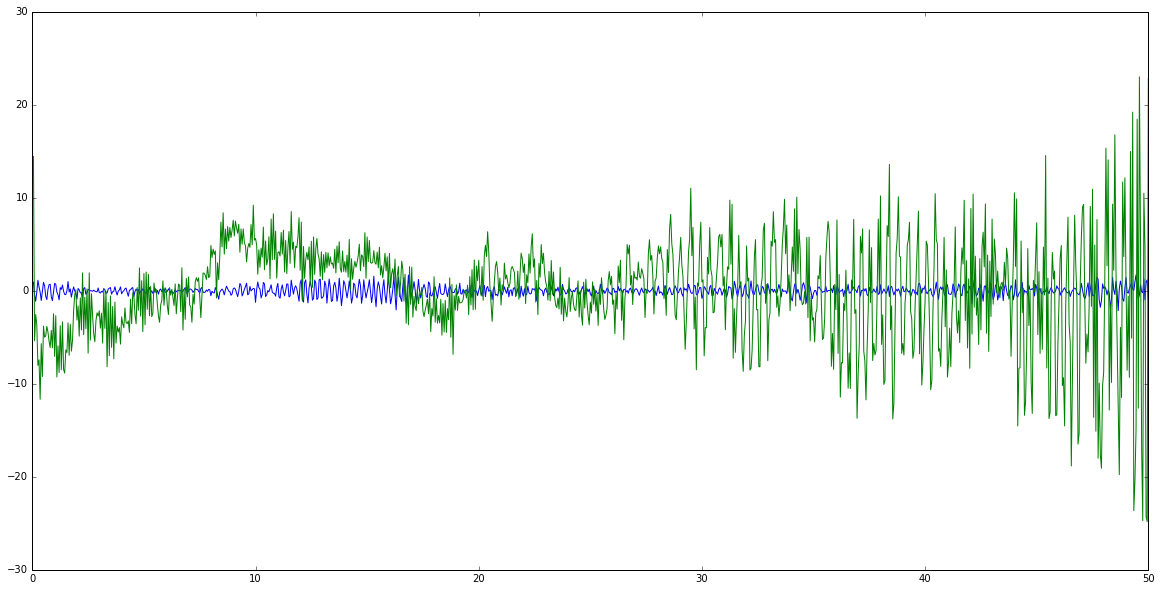

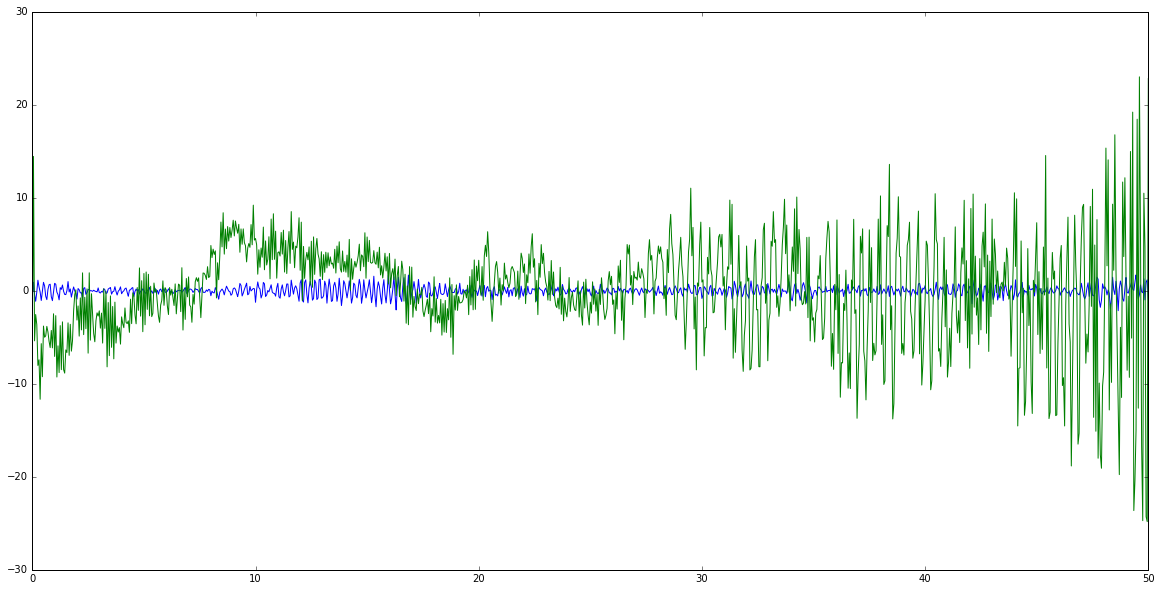

In [4]:
u0 = np.load('data/iter: 5000_mm_cnot total_time: 50.0, steps: 1000, size: 36_uks-Copy1.npy')
figure(figsize=(20,10))
plot(np.linspace(50./1000,50,1000),u0[0])
plot(np.linspace(50./1000,50,1000),u0[1])


new_u0_x = np.interp(np.linspace(50./2000,50,2000),np.linspace(50./1000,50,1000),u0[0],right=0,left=0)
new_u0_z = np.interp(np.linspace(50./2000,50,2000),np.linspace(50./1000,50,1000),u0[1],right=0,left=0)
figure(figsize=(20,10))
plot(np.linspace(50./2000,50,2000),new_u0_x)
plot(np.linspace(50./2000,50,2000),new_u0_z)

new_u0 = np.zeros([2,2000])
new_u0[0] = new_u0_x
new_u0[1] = new_u0_z

new_u0.shape

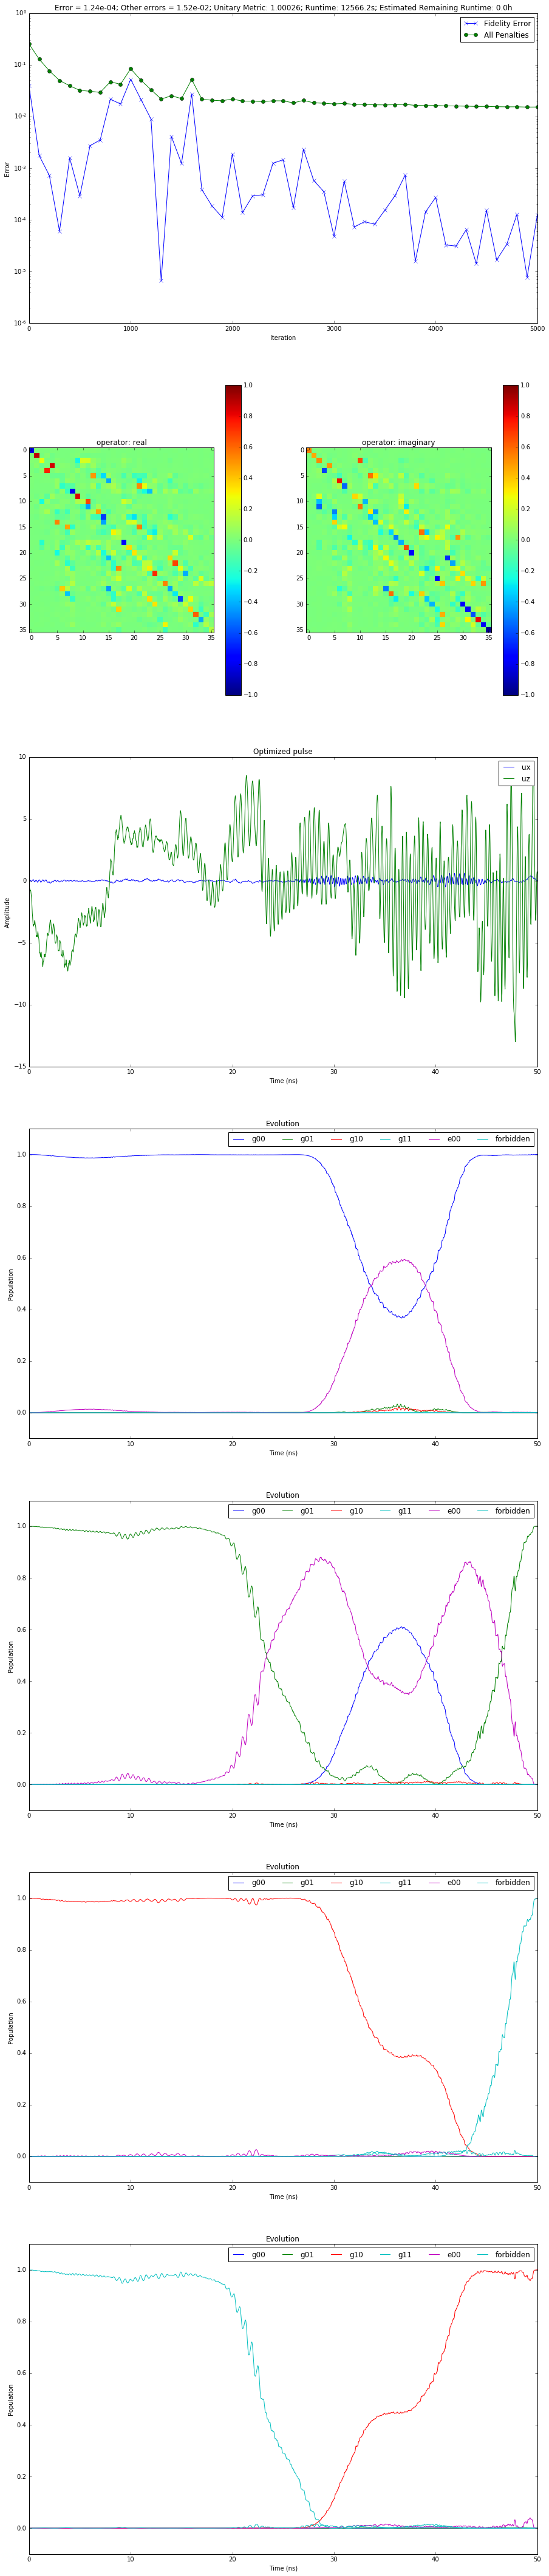

In [5]:
 #Extra options
#reg_coeffs = reg_coeffs,draw = [states_draw_list,states_draw_names] ,forbidden = states_forbidden_list,multi_mode = multi_mode,
#maxA = ops_max_amp,use_gpu = True
uks,U_f = Grape(H0,Hops,Hnames,U,total_time,steps,psi0,convergence, draw = [states_draw_list,states_draw_names],show_plots = True, maxA = ops_max_amp, 
      forbidden = states_forbidden_list, multi_mode=multi_mode, penalty_coeffs = penalty_coeffs, limit_dc = [1],
      method = 'Adam', switch =False,gate="mm_cnot_refine",initial_guess = new_u0)